In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from PIL import Image

# specify GPU
device = torch.device("cuda")



import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/mcdonalds-store-reviews")

print("Path to dataset files:", path)
print(os.listdir(path))


file_path= "/root/.cache/kagglehub/datasets/nelgiriyewithana/mcdonalds-store-reviews/versions/1/McDonald_s_Reviews.csv"
df=pd.read_csv(file_path,encoding="ISO-8859-1")
df.head()






Path to dataset files: /root/.cache/kagglehub/datasets/nelgiriyewithana/mcdonalds-store-reviews/versions/1
['McDonald_s_Reviews.csv']


,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [9]:
df['rating'] = df['rating'].replace({
    '1 star': 1,
    '2 stars': 2,
    '3 stars': 3,
    '4 stars': 4,
    '5 stars': 5
}).astype(int)
df.head()


<ipython-input-9-a374180a1774>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['rating'] = df['rating'].replace({


,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1


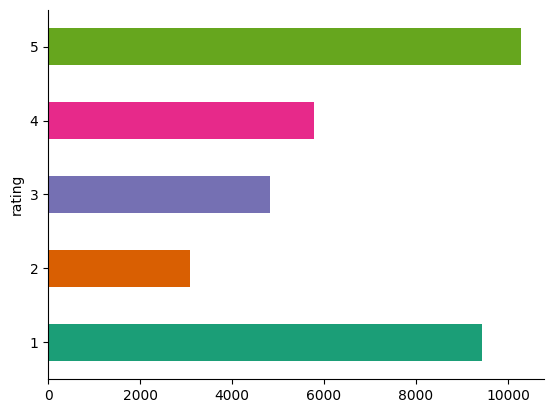

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('rating').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)



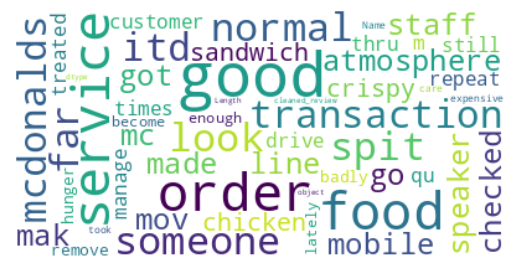

In [ ]:

from wordcloud import WordCloud, ImageColorGenerator
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(df['cleaned_review']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



                                      cleaned_review  \
0  look like someone spit food normal transaction...   
1  itd mcdonalds far food atmosphere go staff mak...   
2  made mobile order got speaker checked line mov...   
3  mc crispy chicken sandwich customer service qu...   
4  repeat order 3 times drive thru still manage m...   

                                      term_frequency  
0  {'look': 0.043478260869565216, 'like': 0.04347...  
1  {'itd': 0.05, 'mcdonalds': 0.05, 'far': 0.05, ...  
2  {'made': 0.03125, 'mobile': 0.03125, 'order': ...  
3  {'mc': 0.125, 'crispy': 0.125, 'chicken': 0.12...  
4  {'repeat': 0.03125, 'order': 0.0625, '3': 0.03...  


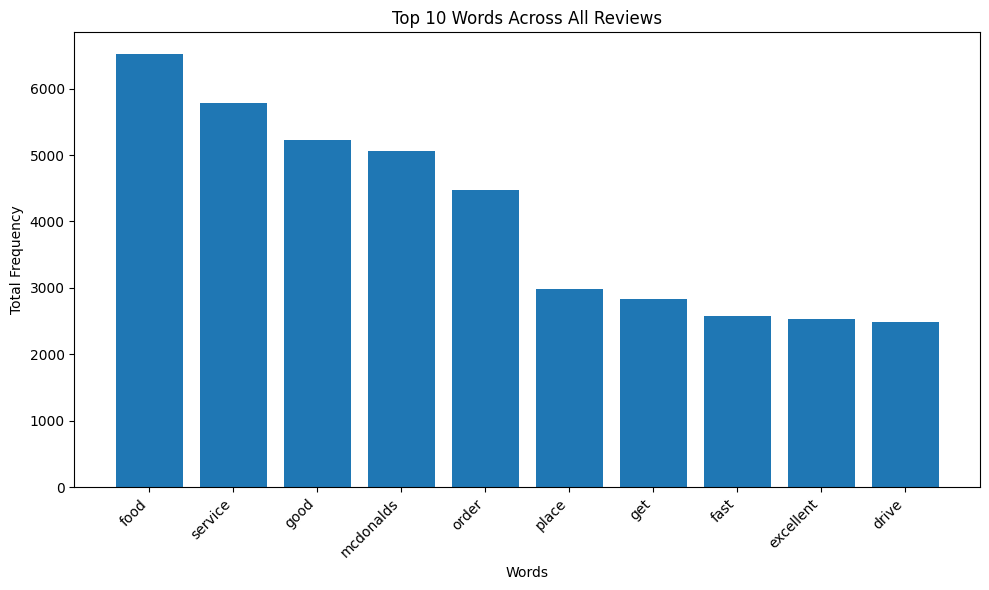

In [ ]:

from collections import Counter

def term_frequency(text):
    """Calculates the term frequency for a given text."""
    words = text.split()
    word_counts = Counter(words)
    total_words = len(words)
    # Use a different variable name to avoid conflict with external 'tf'
    term_freq = {word: count / total_words for word, count in word_counts.items()}
    return term_freq


df['term_frequency'] = df['cleaned_review'].apply(term_frequency)

print(df[['cleaned_review', 'term_frequency']].head())



import matplotlib.pyplot as plt

all_words = []
for tf in df['term_frequency']:
    all_words.extend(list(tf.keys()))

word_counts = Counter(all_words)
top_words_all = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:10])

plt.figure(figsize=(10, 6))
plt.bar(top_words_all.keys(), top_words_all.values())
plt.xlabel("Words")
plt.ylabel("Total Frequency")
plt.title("Top 10 Words Across All Reviews")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
def rate_to_sentiment(rate):
  if rate <=2:
    return "negative"
  elif rate ==3:
    return "nötr"
  else:
    return "positive"

df['rate_sentiment'] = df['rating'].apply(rate_to_sentiment)
print(df[['cleaned_review', 'rate_sentiment']].head(10))

                                      cleaned_review rate_sentiment
0  look like someone spit food normal transaction...       negative
1  itd mcdonalds far food atmosphere go staff mak...       positive
2  made mobile order got speaker checked line mov...       negative
3  mc crispy chicken sandwich customer service qu...       positive
4  repeat order 3 times drive thru still manage m...       negative
5  work door dash locked us wait long line reason...       negative
6  could give location zero customer service woul...       negative
7  came ordered large coffee wno ice handed cup l...       negative
8  went thru drive thru ordered getting home noti...       negative
9  im really huge fan fast food 2 teenage daughte...       positive


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import re
import nltk
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import kagglehub
import os

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = kagglehub.dataset_download("nelgiriyewithana/mcdonalds-store-reviews")
file_path = os.path.join(path, "McDonald_s_Reviews.csv")
df = pd.read_csv(file_path, encoding="ISO-8859-1")

#boş yorumlar  ve eksik veriler silinir.
df['rating'] = df['rating'].astype(str).str.extract(r'(\d+)').astype(int)
df.dropna(subset=['review'], inplace=True)
df = df[df['review'].str.strip() != ""]

# Lemmatizer ve stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = contractions.fix(text) #kısa kelimeleri açar don't->do not
    text = text.lower()
    # özel karakterleri temizler
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # birden fazla boşluğu tek bir boşlukla değiştirip baştaki ve sondaki boşlukları kaldırır
    text = re.sub(r'\s+', ' ', text).strip()
    words = word_tokenize(text) #cümleyi kelimelere ayırır
    # Stopwords ve noktalama işaretlerini çıkarır ve kelimeleri lemmatize eder
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]
    return " ".join(words)

df['review'] = df['review'].apply(clean_text)
#etiketleme
df['label'] = df['rating'].map({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})

df.to_csv("cleaned_review.csv", index=False)

#VERİ TOKENİZASYONU#

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts, tokenizer, max_length=256): #metinleri BERT'in anlayacağı formata çevirir
    encodings = tokenizer.batch_encode_plus(
        texts.tolist(), #listeye çevirir
        max_length=max_length,
        truncation=True, #max aşılırsa keser
        padding='max_length', #doldurma
        return_tensors='pt'
    )
    return encodings #input_ids ve attention_mask döndürülür

encodings = encode_texts(df['review'], tokenizer)
labels = torch.tensor(df['label'].values)

#bert için gerekli 3 bileşeni oluşturur
dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#veri batch olarak modele aktarılır . parça para
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Model oluşturma
class SentimentModel(nn.Module):
    def __init__(self, num_labels=3):
        super(SentimentModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        return self.bert(input_ids, attention_mask=attention_mask).logits

model = SentimentModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5) #model ağırlıkları optimize edklir
criterion = nn.CrossEntropyLoss()#kayıp fonk

# Model eğitimi
#her batch için loss ve accuarcu hesaplar
def train(model, train_loader, val_loader, optimizer, criterion, epochs=3):
    for epoch in range(epochs):
        model.train() #model eğitim modunda (katmanların yanlış çalışmasını engeller)
        total_loss, total_correct, train_preds, train_labels = 0, 0, [], []
        for batch in train_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)#crossentropy
            loss.backward() #kayıp fonk elen gradyanları hesaplar
            optimizer.step()
            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == labels).sum().item()

            # Eğitimdeki tahminleri toplama
            train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Eğitim doğruluğu ve F1 skoru hesaplama
        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        # Doğrulama doğruluğu ve F1 skoru hesaplama
        val_acc, val_f1 = evaluate(model, val_loader)

        print(f"Epoch {epoch + 1}: Loss: {total_loss / len(train_loader):.4f}, "
              f"Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
              f"Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")

# Modeli değerlendirme
def evaluate(model, val_loader):
    model.eval()
    true_vals, predictions = [], [] #gerçek etiket ve model tahmini
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            logits = model(input_ids, attention_mask)#model çıktılarını hesaplar
            preds = logits.argmax(dim=1).cpu().numpy() #model tahminleri alınır
            predictions.extend(preds)
            true_vals.extend(labels.cpu().numpy())

    # Accuracy ve F1 skorunu hesapla
    val_acc = accuracy_score(true_vals, predictions)
    val_f1 = f1_score(true_vals, predictions, average='weighted')
    return val_acc, val_f1

# Modeli eğit
train(model, train_loader, val_loader, optimizer, criterion, epochs=3)

# Modeli kaydet ağırlıklarıyla
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), '/content/drive/My Drive/bert_model2.pt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Loss: 0.5212, Train Accuracy: 0.7971, Train F1: 0.7749, Val Accuracy: 0.8251, Val F1: 0.8155
Epoch 2: Loss: 0.4016, Train Accuracy: 0.8444, Train F1: 0.8348, Val Accuracy: 0.8329, Val F1: 0.8230
Epoch 3: Loss: 0.3011, Train Accuracy: 0.8856, Train F1: 0.8819, Val Accuracy: 0.8371, Val F1: 0.8316
Mounted at /content/drive


In [1]:

%%writefile model.py
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification
class SentimentModel(nn.Module):
       def __init__(self, num_labels=3):
           super(SentimentModel, self).__init__()
           self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

       def forward(self, input_ids, attention_mask):
           return self.bert(input_ids, attention_mask=attention_mask).logits



Writing model.py


In [2]:
!pip install fastapi uvicorn pydantic pyngrok nest-asyncio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.7 MB/s eta 0:00:00


In [11]:
from fastapi import FastAPI
from pydantic import BaseModel
import torch
from transformers import BertTokenizer
from model import SentimentModel
import nest_asyncio
import threading
from pyngrok import ngrok, conf
import uvicorn
import requests
import time
from google.colab import drive
drive.mount('/content/drive')
app = FastAPI()

# Model ve tokenizer'ı yükle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = SentimentModel(num_labels=3)
model_path = "/content/drive/My Drive/bert_model2.pt"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Girdi modeli
class TextInput(BaseModel):
      text: str

# Tahmin endpoint'i
@app.post("/predict")
async def predict_sentiment(input_data: TextInput):
      tokens = tokenizer(input_data.text, padding=True, truncation=True, return_tensors="pt")
      tokens = {key: val.to(device) for key, val in tokens.items()}
      with torch.no_grad():
        output = model(tokens['input_ids'], tokens['attention_mask'])
      prediction = torch.argmax(output, dim=1).item()
      sentiment = ["negative", "neutral", "positive"][prediction]
      return {"text": input_data.text, "sentiment": sentiment}

# ngrok bağlantısı
def start_ngrok():
      ngrok.set_auth_token("2vM77qp5o5sFaXRsPqIvT9LlnnB_fJmdFA1Xq7Tw7GmgB7BB")
      conf.get_default().config_path = "/root/.ngrok2/ngrok.yml"
      ngrok.kill()
      tunnel = ngrok.connect(8000)
      public_url = tunnel.public_url
      print("Public URL:", public_url)
      return public_url

# API sunucusunu başlat
def run_api():
      try:
          uvicorn.run(app, host="0.0.0.0", port=8000)
      except Exception as e:
          print("API zaten çalışıyor olabilir:", e)

# API'yi başlat
nest_asyncio.apply()
thread = threading.Thread(target=run_api)
thread.start()
time.sleep(5)

public_url = start_ngrok()
print("Uygulama erişim linki:", public_url)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:     Started server process [218]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): address already in use
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


Public URL: https://02ad-34-105-36-66.ngrok-free.app
Uygulama erişim linki: https://02ad-34-105-36-66.ngrok-free.app


In [12]:

import ipywidgets as widgets
from IPython.display import display,clear_output



# ipywidgets ile kullanıcı arayüzü oluştur
text_input = widgets.Text(
    value='',
    placeholder='yorum yaz',
    description='yorum',
    disabled=False
)

button = widgets.Button(description="Tahmin et")
output = widgets.Output()

def on_button_click(b):
    with output:
        clear_output()
        data = {"text": text_input.value}
        try:
            # public_url'yi doğru şekilde kullanıyoruz
            response = requests.post(f"{public_url}/predict", json=data)
            print("Response JSON:", response.json())  # Yanıtın tamamını yazdır
            sentiment = response.json().get("sentiment", "Yanıt bulunamadı")  # 'sentiment' anahtarını güvenli bir şekilde al
            print("Tahmin:", sentiment)
        except Exception as e:
            print(f"Hata oluştu: {e}")

button.on_click(on_button_click)

display(text_input, button, output)

Text(value='', description='yorum', placeholder='yorum yaz')

Button(description='Tahmin et', style=ButtonStyle())

Output()